In [1]:
import sys
sys.path.append("../")
import warnings
from pathlib import Path
from ocpmodels.common.utils import make_script_trainer
import numpy as np

from ocpmodels.common.utils import (
    build_config,
    resolve,
    setup_imports,
    setup_logging,
    update_from_sbatch_py_vars,
)
from ocpmodels.common.flags import flags
from ocpmodels.common.registry import registry
import matplotlib.pyplot as plt

In [2]:
import lmdb

data_path = "/network/scratch/s/schmidtv/ocp/datasets/ocp/dense/oc20dense.lmdb"
lmdb_path = Path(data_path)

import os
print("File exists", os.path.isfile(data_path))

username = os.environ["USER"]
fletter = username[0]

File exists True


In [3]:
# Download mappings in data file
!mkdir -p /network/scratch/$fletter/$username/ocp/data/dense/metadata/
!wget -P /network/scratch/$fletter/$username/ocp/data/dense/metadata/ -c https://dl.fbaipublicfiles.com/opencatalystproject/data/adsorbml/oc20_dense_mappings.tar.gz 
!tar -xvf /network/scratch/$fletter/$username/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz -C /network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/
!rm /network/scratch/$fletter/$username/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz

--2023-11-22 03:54:42--  https://dl.fbaipublicfiles.com/opencatalystproject/data/adsorbml/oc20_dense_mappings.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.161.213.84, 3.161.213.42, 3.161.213.24, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.161.213.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5137126 (4.9M) [application/x-tar]
Saving to: ‘/network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz’

oc20_dense_mappings 100%[===================>]   4.90M  11.9MB/s    in 0.4s    

2023-11-22 03:54:43 (11.9 MB/s) - ‘/network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz’ saved [5137126/5137126]

oc20dense_compute.pkl
oc20dense_mapping.pkl
oc20dense_ref_energies.pkl
oc20dense_tags.pkl
oc20dense_targets.pkl


In [4]:
#Read mappings
import joblib
from pprint import pprint

data_path = f"/network/scratch/{fletter}/{username}/ocp/data/dense/metadata/"

compute_mappings = joblib.load(data_path + "oc20dense_compute.pkl")
print(f"Length of compute mappings: {len(compute_mappings)}")
print(f"Keys:")
pprint(compute_mappings.keys())
print(f"Example:")
pprint(list(compute_mappings.values())[0])


Length of compute mappings: 973
Keys:
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65',

In [5]:
#Compute mappings of the LMDB file
mapping = joblib.load(data_path + "oc20dense_mapping.pkl")
print(f"Length of mappings: {len(mapping)}")
pprint(mapping.keys())
print(f"Example:")
pprint(list(mapping.values())[0])

Length of mappings: 85658
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

In [6]:
ref_energies = joblib.load(data_path + "oc20dense_ref_energies.pkl")
print(f"Length of ref energies: {len(ref_energies)}")
pprint(ref_energies.keys())
print(f"Example:")
pprint(list(ref_energies.values())[0])

Length of ref energies: 973
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65', '18_424_1

In [7]:
tags = joblib.load(data_path + "oc20dense_tags.pkl")
print(f"Length of tags: {len(tags)}")
pprint(tags.keys())
print(f"Example:")
pprint(list(tags.values())[0])

Length of tags: 973
dict_keys(['17_405_22', '10_4609_10', '78_8183_185', '6_8845_80', '80_3227_39', '9_3218_60', '45_7371_26', '45_241_8', '25_860_62', '74_2292_35', '7_8930_215', '69_5384_21', '7_3987_13', '7_6875_3', '8_2255_14', '40_3261_77', '6_2097_100', '16_7283_37', '71_2537_62', '68_1837_17', '7_10352_9', '6_10420_2', '72_785_14', '56_2693_37', '8_10020_72', '73_3529_3', '58_2767_46', '71_2233_67', '14_1662_2', '57_7_1', '1_1728_33', '16_6384_9', '14_6259_6', '45_7673_39', '26_10797_43', '42_6921_7', '4_2274_75', '7_9289_5', '19_1900_29', '70_3568_29', '41_6957_10', '80_9443_1', '71_6565_251', '13_734_133', '13_1974_3', '80_3628_6', '25_2632_4', '57_2719_41', '7_10319_5', '58_2501_44', '8_414_14', '71_6078_115', '6_5733_41', '14_5218_40', '9_2241_20', '26_2047_3', '71_2090_36', '1_3984_8', '8_6142_27', '52_6147_10', '6_3558_9', '71_9826_55', '71_3086_27', '4_7696_78', '8_2296_0', '80_2234_20', '6_3876_5', '6_3391_74', '0_6055_19', '71_6359_40', '7_1098_11', '19_1087_50', '41_61

In [9]:
targets = joblib.load(data_path + "oc20dense_targets.pkl")
print(f"Length of targets: {len(targets)}")
pprint(targets.keys())
print(f"Example:")
pprint(list(targets.values())[0])

Length of targets: 973
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65', '18_424_1', '1

In [10]:
env = lmdb.open(
    str(lmdb_path),
    subdir=False,
    lock=False,
    readahead=False,
    meminit=False,
    max_readers=1,
    readonly=True,
)

n_dataset = env.stat()["entries"]
print(f"Number of examples in dataset: {n_dataset}")

Number of examples in dataset: 85658


In [11]:
import ase.io
from ase.io.trajectory import Trajectory
from ase.io import extxyz
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.visualize.plot import plot_atoms
from ase import Atoms
from IPython.display import Image
from io import StringIO
import pickle

# Read first example
with env.begin(write=False) as txn:
    key, value = next(iter(txn.cursor()))
    structure = pickle.loads(value)
    pprint(structure.keys())
    structure_mapping = mapping[structure["sid"]]
    ref_energy = ref_energies[structure_mapping["system_id"]]
    target_energy = [energy for energy in targets[structure_mapping["system_id"]] if energy[0] == structure_mapping["config_id"]][0]

print(f"Number of atoms: {(structure['natoms'])}")
pprint(structure)
structure["pos"].shape

['sid',
 'natoms',
 'pos',
 'edge_index',
 'atomic_numbers',
 'config',
 'tags',
 'fixed',
 'cell',
 'cell_offsets']
Number of atoms: 98
Data(pos=[98, 3], cell=[1, 3, 3], atomic_numbers=[98], natoms=98, tags=[98], edge_index=[2, 4581], cell_offsets=[4581, 3], fixed=[98], sid=0, config=1)


torch.Size([98, 3])

In [12]:
import numpy as np
pprint(f"Reference energy: {ref_energy}")
print(f"Target energy: {target_energy[1]}")

'Reference energy: -453.24573592'
Target energy: 0.19145722000001797


In [13]:
pprint("Tags are already in the structure:")
pprint(structure["tags"])

'Tags are already in the structure:'
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        2, 2])


In [14]:
pprint("This is the mapping of the structure:")
structure_mapping

'This is the mapping of the structure:'


{'system_id': '17_405_22',
 'config_id': 'rand46',
 'mpid': 'mp-20112',
 'miller_idx': (2, 0, 1),
 'shift': 0.167,
 'top': True,
 'adsorbate': '*C*C',
 'adsorption_site': array([ 2.56796181,  4.52565477, 28.3339601 ])}

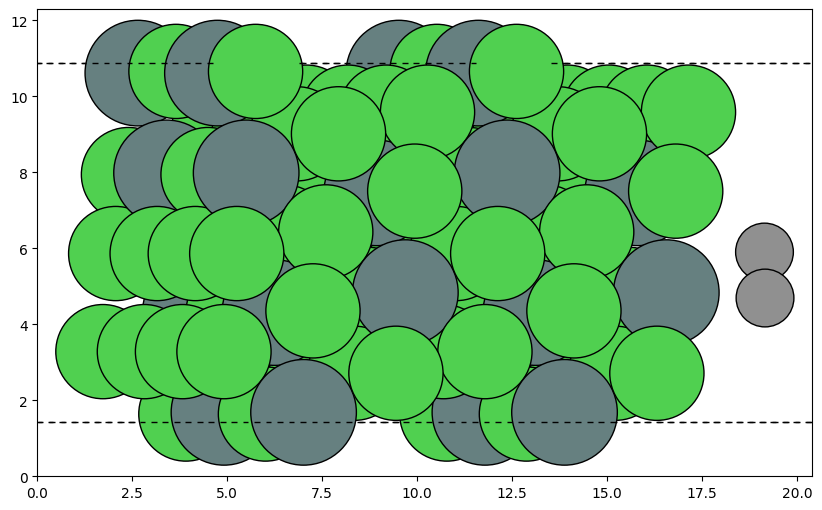

In [15]:
ase_atoms = Atoms(
    symbols=structure["atomic_numbers"],
    positions=structure["pos"],
    cell=structure["cell"].squeeze(),
    pbc=True,
)

# Plot structure
fig, ax = plt.subplots(figsize=(10, 10))
plot_atoms(ase_atoms, rotation="90x,90y,90z", show_unit_cell=True, ax=ax)
plt.show()

In [16]:
#Number of total target energies:
n = np.sum(np.array([len(targets[target]) for target in targets]))
print(f"Number of total target energies: {n}")
print(f"Number of system configurations: {n_dataset}")

Number of total target energies: 65073
Number of system configurations: 85658


We notice that there is a big difference between the total number of configurations and the total number of reported relaxation energy targets (around 20k are missing). This might be due to the fact that some DFT relaxations are rejected from the dataset because of the hypothesis detailed in the paper (might need to confirm that later).

In [17]:
from tqdm import tqdm
from collections import defaultdict
#collectionc counter

#Iterate over all examples using lmdb
with env.begin(write=False) as txn:
    for i in tqdm(range(n_dataset)):
        value = txn.get(f"{i}".encode())
        structure = pickle.loads(value)
        #######
        # Do something with the dataset
        break
        ######


  0%|          | 0/85658 [00:00<?, ?it/s]


In [18]:
import pandas as pd

columns = ["system_id", "adsorbate", "relaxed_energy", "config_id", "target_energy"]
df = pd.DataFrame(columns=columns)
rows = list()
for sid, config_mapping in tqdm(mapping.items()):
    system_id = config_mapping["system_id"]
    relaxed_energy = ref_energies[system_id]

    target_energy = [energy for energy in targets[system_id] if energy[0] == config_mapping["config_id"]]

    assert len(target_energy) <= 1, "More than one target energy found, this is strange"

    if len(target_energy) == 0:
        target_energy = None
    else:
        target_energy = target_energy[0][1]
    
    new_row = pd.DataFrame({"system_id": system_id, "adsorbate": config_mapping["adsorbate"], "relaxed_energy": relaxed_energy, "config_id": config_mapping["config_id"], "target_energy": target_energy}, index=[0])
    rows.append(new_row)
df = pd.concat(rows, ignore_index=True)

100%|██████████| 85658/85658 [00:29<00:00, 2934.52it/s]


In [19]:
print(f"Number of unique system ids (adsorbate+surface material): {len(df)}")
print(f"Number of unique adsorbates: {len(df['adsorbate'].unique())}")

Number of unique system ids (adsorbate+surface material): 85658
Number of unique adsorbates: 74


In [20]:
df.head(5)

,system_id,adsorbate,relaxed_energy,config_id,target_energy
0,17_405_22,*C*C,-453.245736,rand46,0.191457
1,10_4609_10,*CH2*O,-455.644701,rand18,-3.86779
2,78_8183_185,*NO3,-458.608610,heur6,3.977996
3,6_8845_80,*CH,-755.696586,rand64,None
4,80_3227_39,*ONOH,-634.548378,rand65,None


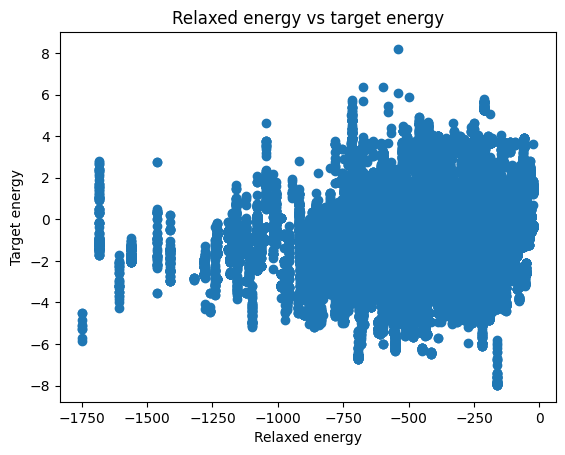

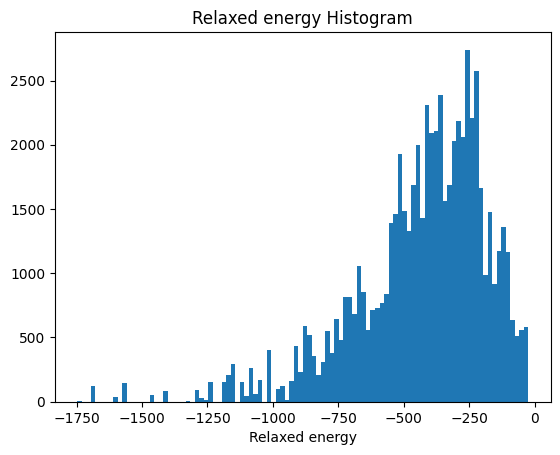

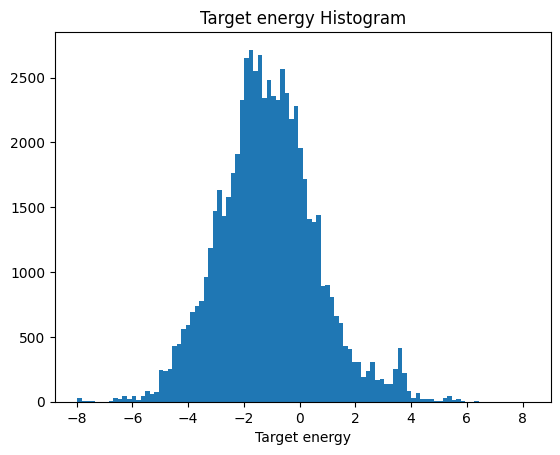

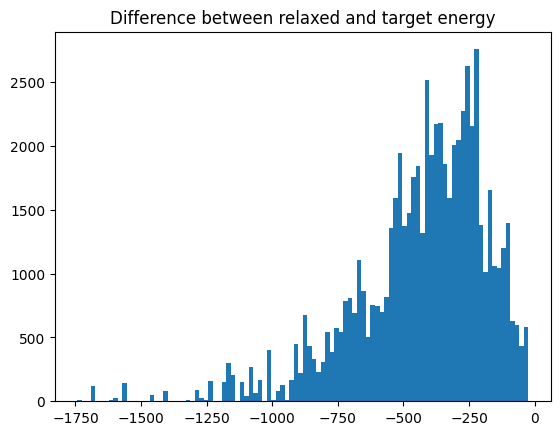

In [21]:
df_clean = df.dropna()

plt.plot(df_clean["relaxed_energy"], df_clean["target_energy"], "o")
plt.title("Relaxed energy vs target energy")
plt.xlabel("Relaxed energy")
plt.ylabel("Target energy")
plt.show()

plt.hist(df_clean["relaxed_energy"], bins=100)
plt.title("Relaxed energy Histogram")
plt.xlabel("Relaxed energy")
plt.show()

plt.hist(df_clean["target_energy"], bins=100)
plt.title("Target energy Histogram")
plt.xlabel("Target energy")
plt.show()

plt.hist(df_clean["relaxed_energy"] - df_clean["target_energy"], bins=100)
plt.title("Difference between relaxed and target energy")
plt.show()


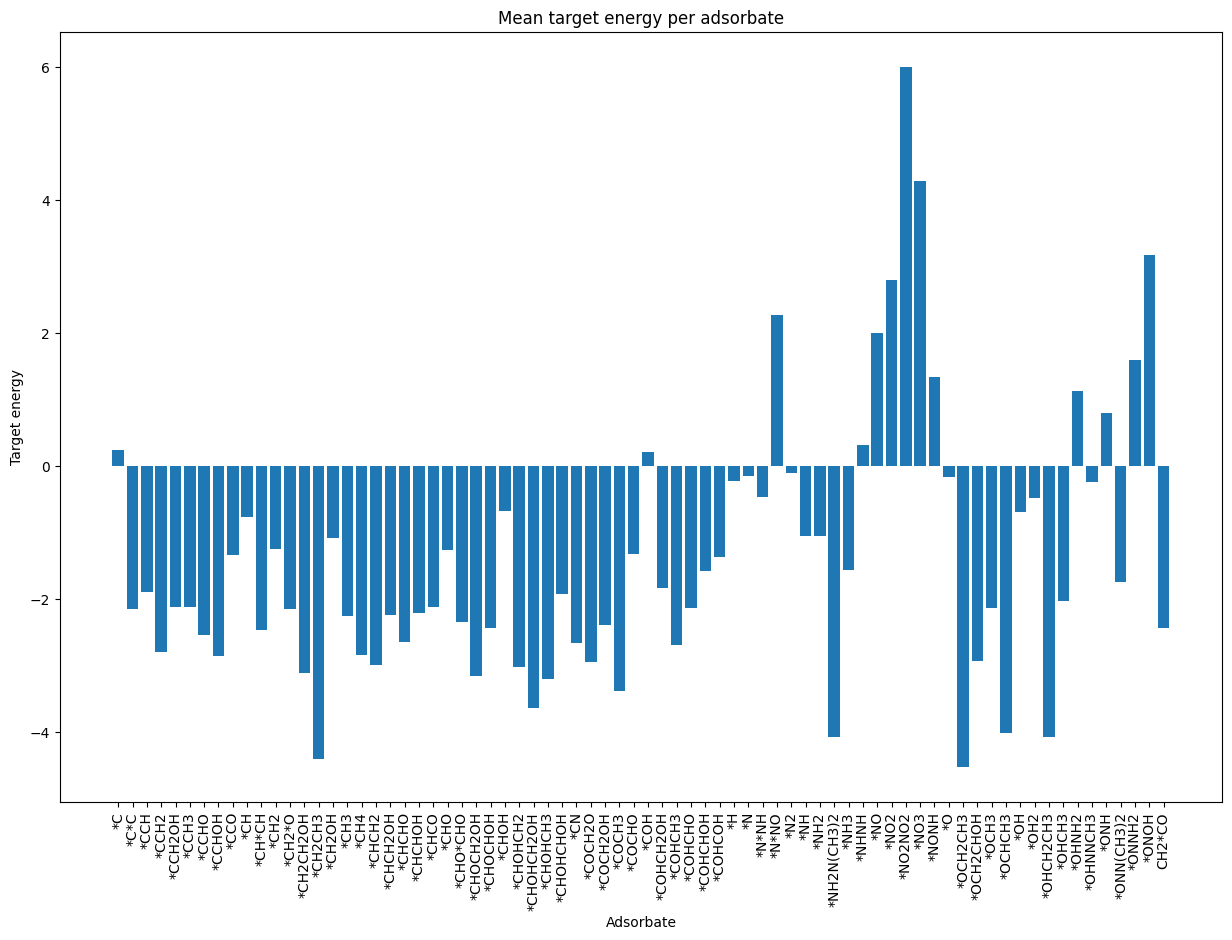

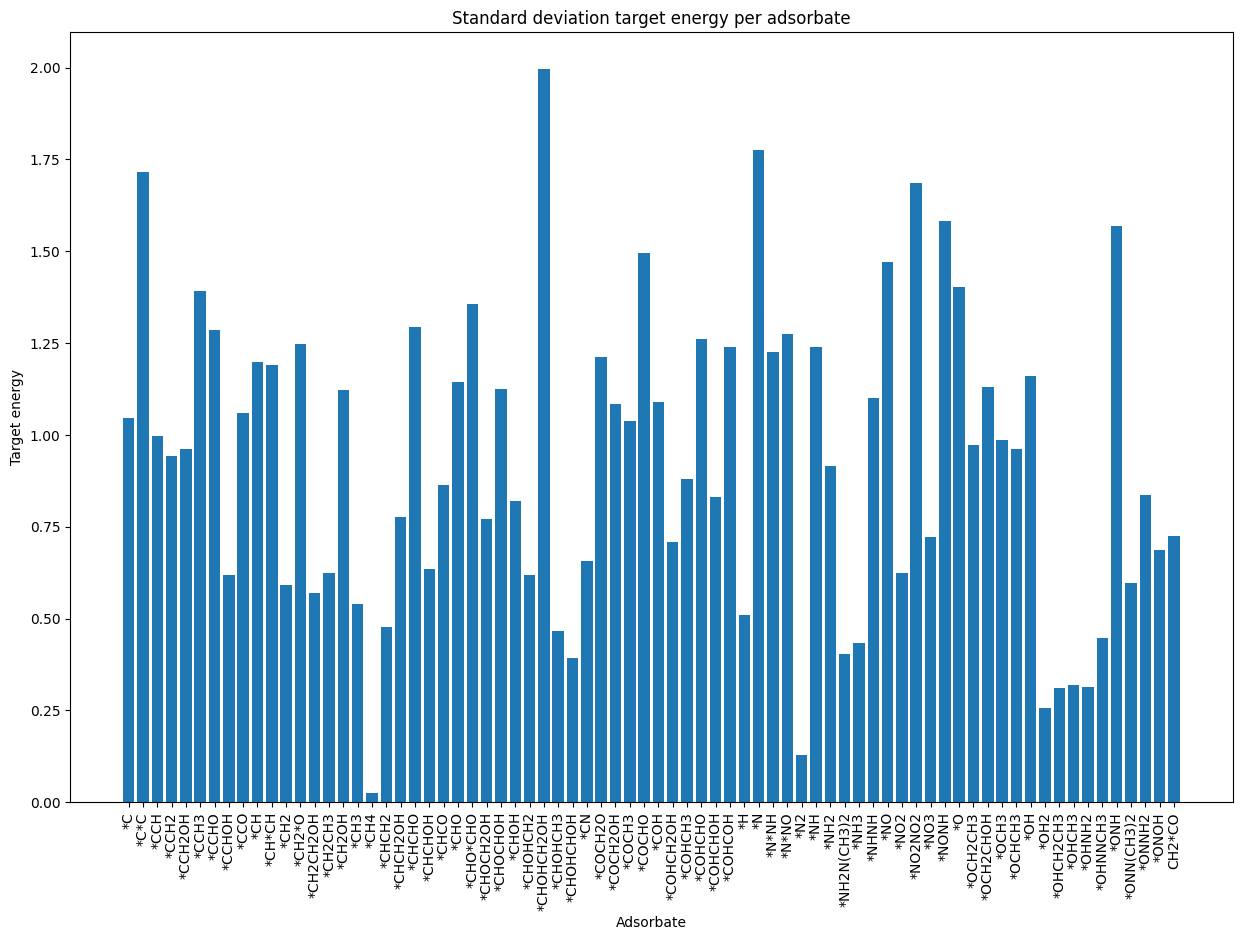

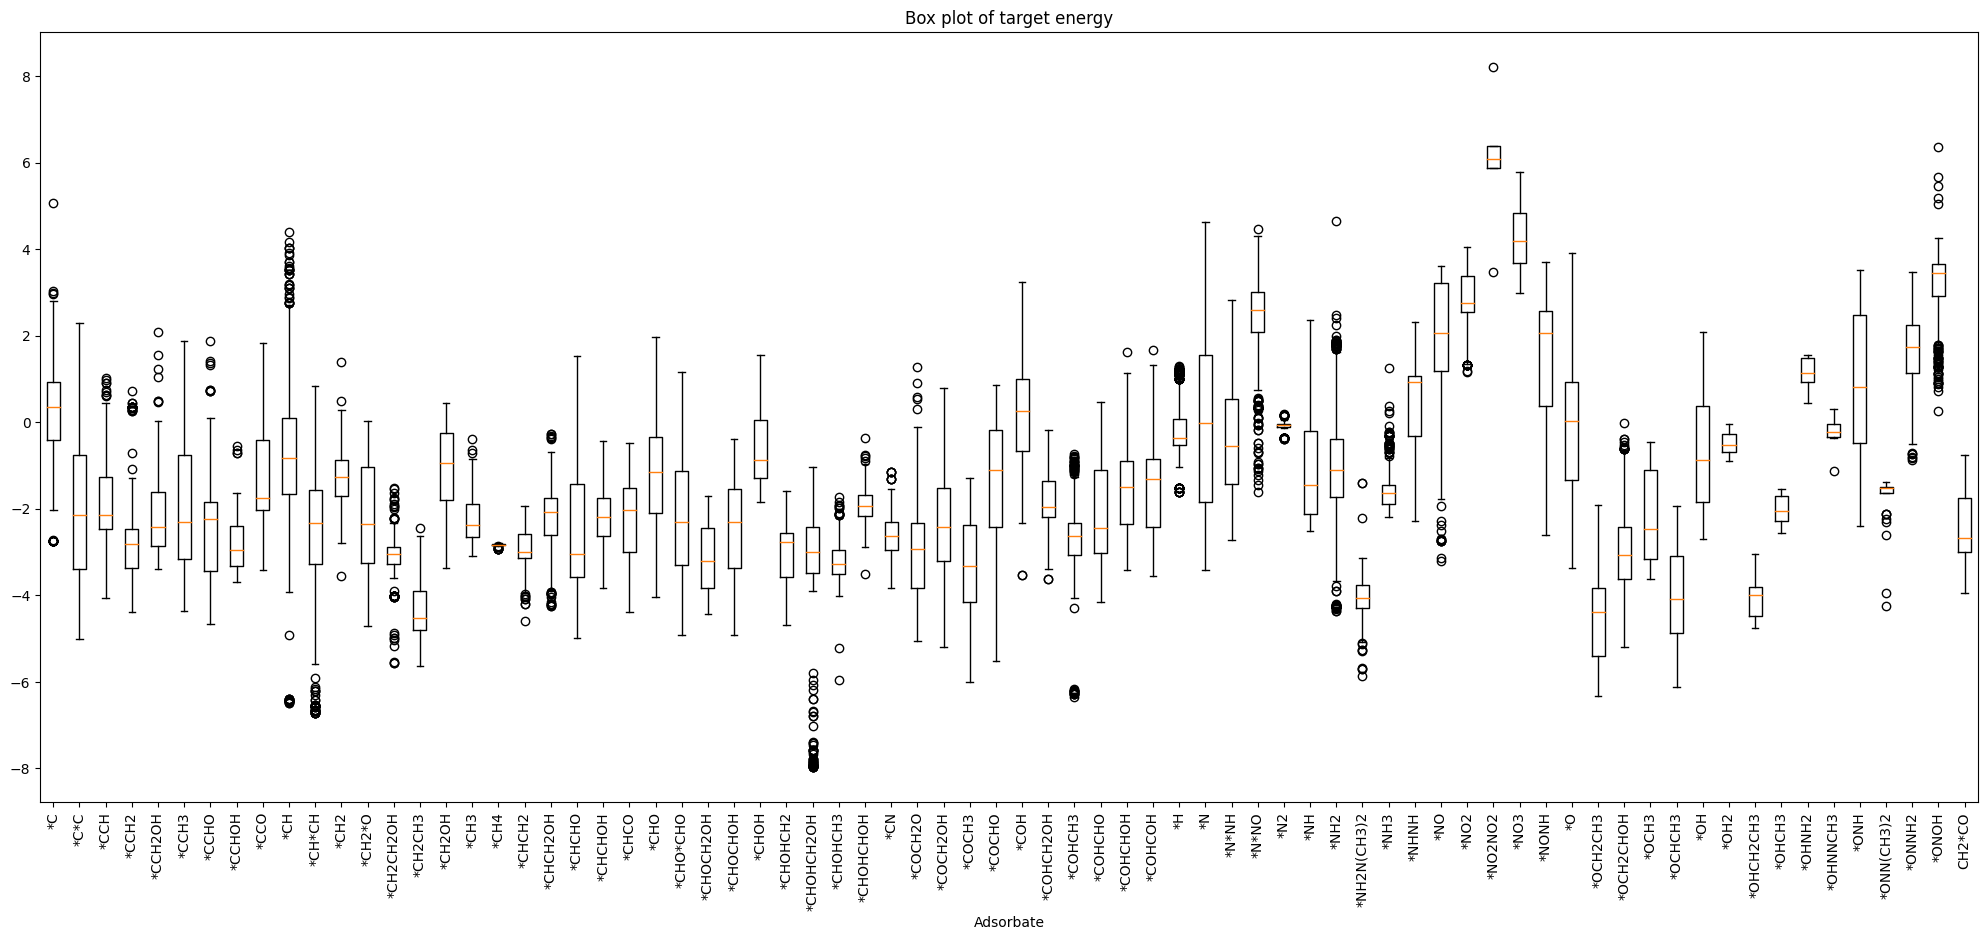

In [22]:
df_adsorbate = df_clean.groupby("adsorbate")
mean_per_adsorbate = df_adsorbate[["relaxed_energy", "target_energy"]].mean()
std_per_adsorbate = df_adsorbate[["relaxed_energy", "target_energy"]].std()
adsorbates = mean_per_adsorbate.index

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(mean_per_adsorbate.index, mean_per_adsorbate["target_energy"])
plt.title("Mean target energy per adsorbate")
plt.xlabel("Adsorbate")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(std_per_adsorbate.index, std_per_adsorbate["target_energy"])
plt.title("Standard deviation target energy per adsorbate")
plt.xlabel("Adsorbate")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

# Box plot per adsorbate
fig, _ = plt.subplots(figsize=(25, 10))
plt.boxplot(df_clean.groupby("adsorbate")["target_energy"].apply(list))
plt.xticks(np.arange(len(adsorbates))+1, adsorbates, rotation=90)
plt.title("Box plot of target energy")
plt.xlabel("Adsorbate")
plt.show()


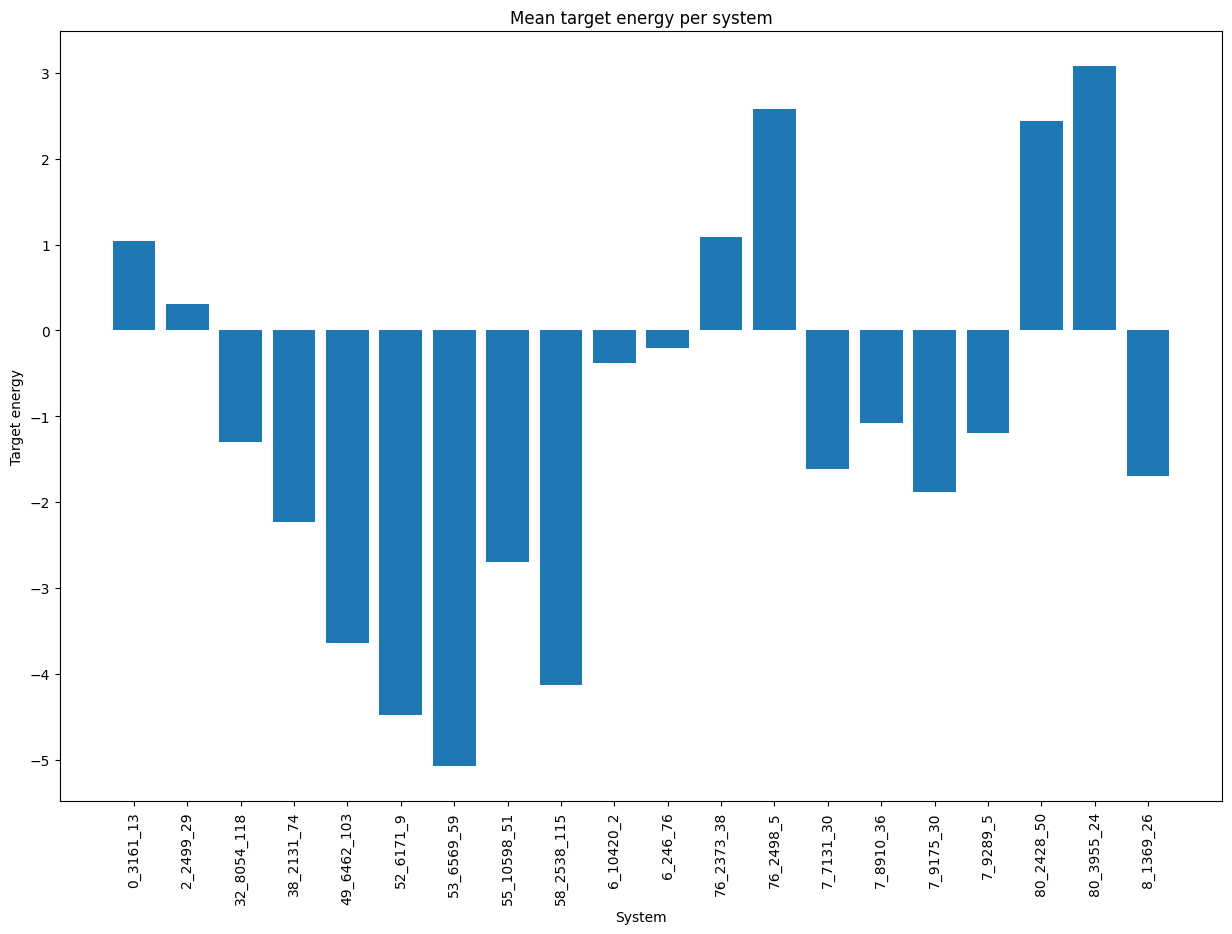

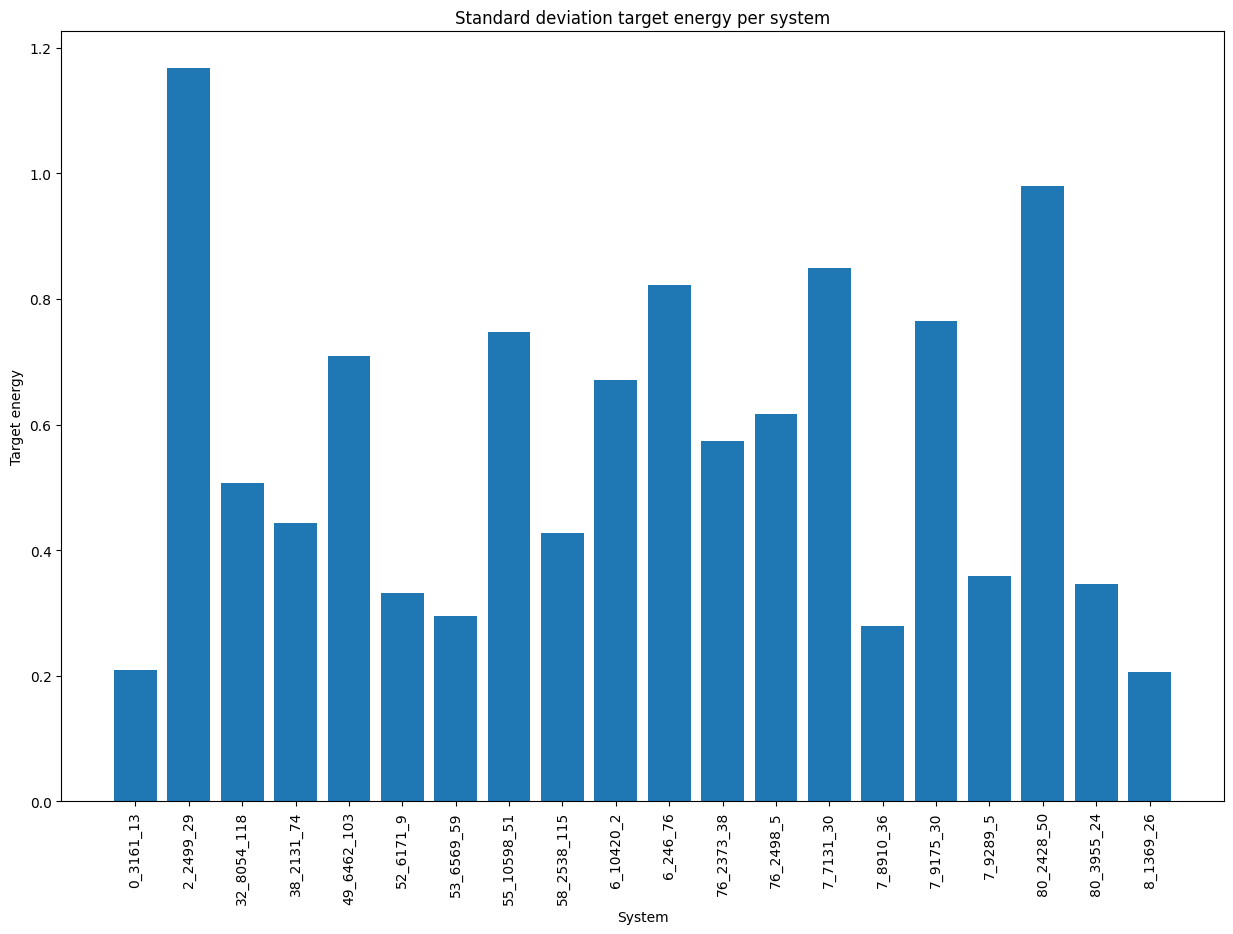

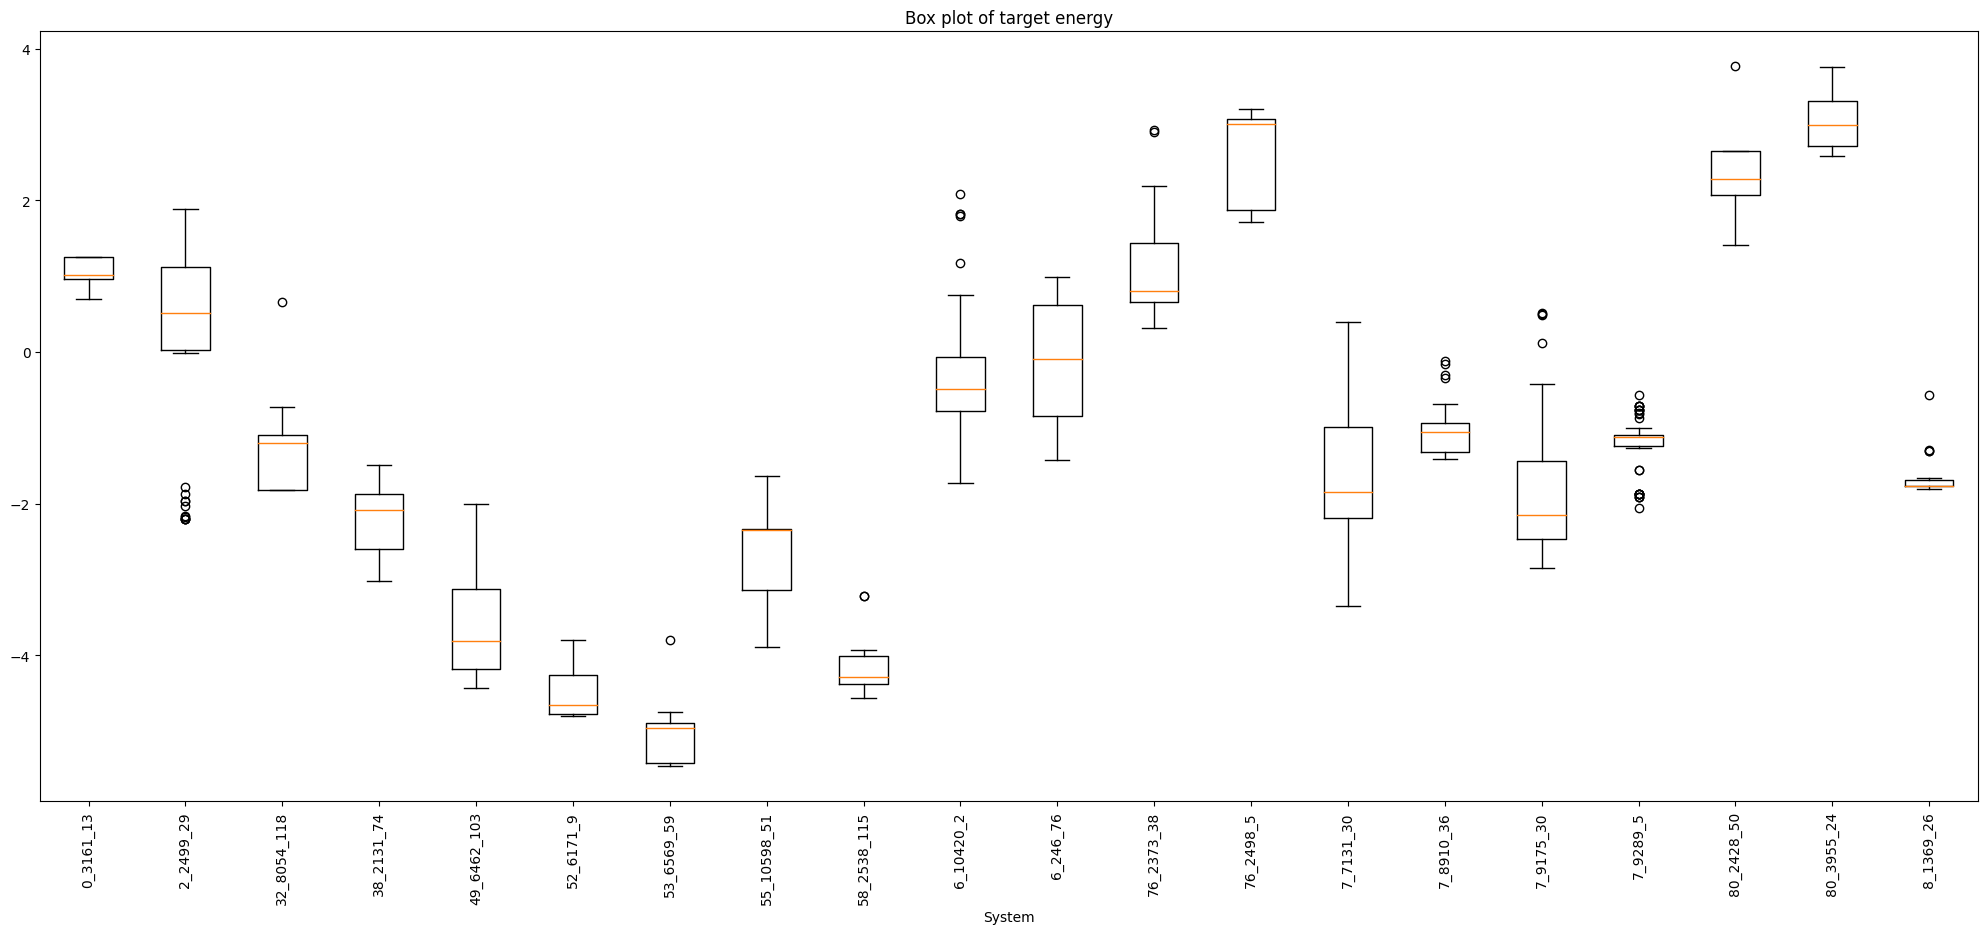

In [23]:
n = 20
systems = np.random.permutation(df_clean["system_id"].unique())[:n]
df_subset = df_clean[df_clean["system_id"].isin(systems)]
df_system = df_subset.groupby("system_id")
mean_per_system = df_system[["relaxed_energy", "target_energy"]].mean()
std_per_system = df_system[["relaxed_energy", "target_energy"]].std()
system = mean_per_system.index

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(mean_per_system.index, mean_per_system["target_energy"])
plt.title("Mean target energy per system")
plt.xlabel("System")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(std_per_system.index, std_per_system["target_energy"])
plt.title("Standard deviation target energy per system")
plt.xlabel("System")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

# Box plot per system
fig, _ = plt.subplots(figsize=(25, 10))
plt.boxplot(df_system["target_energy"].apply(list))
plt.xticks(np.arange(len(system))+1, system, rotation=90)
plt.title("Box plot of target energy")
plt.xlabel("System")
plt.show()


# Study the splits of the validation dataset and subsampling

In [24]:
df_description = pd.DataFrame(columns=["system_id", "adsorbate", "config_id", "mpid"])
rows = list()
for sid, config_mapping in tqdm(mapping.items()):
    system_id = config_mapping["system_id"]
    relaxed_energy = ref_energies[system_id]
    
    new_row = pd.DataFrame({"system_id": system_id, "adsorbate": config_mapping["adsorbate"], "config_id": config_mapping["config_id"], "mpid": config_mapping["mpid"],}, index=[0])
    rows.append(new_row)
df_description = pd.concat(rows, ignore_index=True)

100%|██████████| 85658/85658 [00:12<00:00, 6782.07it/s]


In [25]:
import json

metadata_path = "/network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads/"

splits = ["id", "ood_ads", "ood_both", "ood_cat"]
oc20_metadata = {}
for split in splits:
    oc20_metadata[split] = json.loads(open(metadata_path + f"is2re-all-val_{split}.json", "r").read())

print(oc20_metadata["id"].keys())

dict_keys(['bulk_id', 'ads_id', 'bulk_mpid', 'bulk_symbols', 'ads_symbols', 'miller_index', 'shift', 'top', 'adsorption_site', 'class', 'anomaly', 'source', 'ds_idx'])


In [26]:
df_description["ood_ads"] = df_description["adsorbate"].isin(oc20_metadata["ood_ads"]["ads_symbols"])
df_description["ood_cat"] = df_description["mpid"].isin(oc20_metadata["ood_cat"]["bulk_mpid"])
df_description["ood_both"] = df_description["adsorbate"].isin(oc20_metadata["ood_both"]["ads_symbols"]) & df_description["mpid"].isin(oc20_metadata["ood_both"]["bulk_mpid"])
df_description["id"] = df_description["adsorbate"].isin(oc20_metadata["id"]["ads_symbols"]) & df_description["mpid"].isin(oc20_metadata["id"]["bulk_mpid"])


In [27]:
df_description

,system_id,adsorbate,config_id,mpid,ood_ads,ood_cat,ood_both,id
0,17_405_22,*C*C,rand46,mp-20112,False,True,False,False
1,10_4609_10,*CH2*O,rand18,mp-21235,False,False,False,True
2,78_8183_185,*NO3,heur6,mp-1214064,False,True,False,False
3,6_8845_80,*CH,rand64,mp-1220882,True,True,True,False
4,80_3227_39,*ONOH,rand65,mp-1221484,True,False,False,False
...,...,...,...,...,...,...,...,...
85653,65_2270_86,*N*NH,heur151,mp-30357,False,True,False,False
85654,73_454_9,*NONH,rand75,mp-2776,False,True,False,False
85655,42_7688_189,*COHCHOH,rand68,mp-541875,False,False,False,True
85656,0_6055_19,*O,heur11,mp-13963,False,False,False,True


In [29]:
print(df_description["id"].value_counts())
print(df_description["ood_ads"].value_counts())
print(df_description["ood_both"].value_counts())
print(df_description["ood_cat"].value_counts())

id
False    65198
True     20460
Name: count, dtype: int64
ood_ads
True     44205
False    41453
Name: count, dtype: int64
ood_both
False    62860
True     22798
Name: count, dtype: int64
ood_cat
True     43791
False    41867
Name: count, dtype: int64


In [31]:
print("Number of unique systems in the ID split:")
print(len(df_description[df_description["id"]]["system_id"].unique()))

244

In [33]:
# Isolate splits
for split in splits:
    !mkdir -p /network/scratch/s/schmidtv/ocp/datasets/ocp/dense/{split}/
    lmdb_split_path = f"/network/scratch/s/schmidtv/ocp/datasets/ocp/dense/{split}/oc20dense_{split}.lmdb"

    print(f"Creating lmdb file for split: {split}")

    # Open the new file with the same config as the original env
    env_split = lmdb.open(
        str(lmdb_split_path),
        subdir=False,
        map_size=1e12,
        readonly=False,
        meminit=False,
        map_async=True,
    )

    # empty the file:
    with env_split.begin(write=True) as txn_split:
        txn_split.drop("".encode(), delete=False)

    env_split.sync()

    #Iterate over all examples using lmdb
    with env.begin(write=False) as txn:
        with env_split.begin(write=True) as txn_split:
            for i in tqdm(range(n_dataset)):
                if not df_description.iloc[i][split]:
                    continue
                value = txn.get(f"{i}".encode())
                structure = pickle.loads(value)

                txn_split.put(f"{i}".encode(), pickle.dumps(structure))
    env_split.sync()
    env_split.close()




/tmp/ipykernel_39170/2694114613.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env_split = lmdb.open(
100%|██████████| 85658/85658 [01:31<00:00, 933.93it/s] 
